In [1]:
using QuantumOptics
using DiffEqNoiseProcess
using PyPlot
using LaTeXStrings
using Random
using DelimitedFiles
using NPZ, Printf
using LinearAlgebra
using DifferentialEquations
using SpecialFunctions
using SparseArrays
using StatsBase
using Optim
using JLD2
using BenchmarkTools
include("HenryLib.jl")

┌ Warning: Error requiring `KrylovKit` from `LinearSolve`
│   exception = (LoadError("/Users/henryhunt/.julia/packages/LinearSolve/qCLK7/ext/LinearSolveKrylovKitExt.jl", 1, ArgumentError("Package LinearSolve does not have KrylovKit in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have LinearSolve checked out for development and have\n  added KrylovKit as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with LinearSolve")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000011669466b, Ptr{Nothing} @0x0000000116694837, Ptr{Nothing} @0x0000000101974893, Ptr{Nothing} @0x00000001019aa4db, Ptr{Nothing} @0x00000001019a92e7, Ptr{Nothing} @0x00000001019a9663, Ptr{Nothing} @0x00000001019a9c43, Ptr{Nothing} @0x00000001019aa9d7, Ptr{Nothing} @0x000000011846c883, Ptr{Nothing

make_white_noise (generic function with 1 method)

In [9]:
function diag_dicke(λrel; κ = 2π*0.15, Δc = 2π*20, ωz = 2π*0.01, fockmax = 4, Nspin=20, Nvecs=4)
    fb = FockBasis(fockmax)
    sb = SpinBasis(Nspin//2)
    bases = [sb, fb]
    a = mb(destroy(fb), bases, 2)
    Sx = mb(sigmax(sb), bases, 1)/2
    Sy = mb(sigmay(sb), bases, 1)/2
    Sz = mb(sigmaz(sb), bases, 1)/2

    # κ = 2π*0.15 # MHz
    # Δc = 2π*20 # MHz
    # ωz = 2π*0.01 # MHz
    λc = 1/2*sqrt((Δc^2+κ^2)/Δc * ωz) 
    λ = λrel*λc

    C = sqrt(2*κ)*a
    H = Δc*dagger(a)*a + ωz*Sz + 2*λ*(dagger(a) + a)*Sx/sqrt(Nspin)

    E, states = eigenstates((H + dagger(H))/2, Nvecs, info=false);
    return E, states, fb, sb, bases, a, Sx, Sy, Sz
end

diag_dicke (generic function with 1 method)

In [10]:
function dicke_model_SS_rho(λrel; κ=2π * 0.15, Δc=2π * 20, ωz=2π * 0.01, fockmax=4, Nspin=20)
    fb, sb, bases, a, Sx, Sy, Sz = make_operators(fockmax, Nspin)
    λc = 1 / 2 * sqrt((Δc^2 + κ^2) / Δc * ωz)
    λ = λrel * λc

    H0 = Δc * dagger(a) * a + ωz * Sz + 2 * λ * (dagger(a) + a) * Sx / sqrt(Nspin)
    C = sqrt(2 * κ) * a

    ρ = steadystate.iterative(H0, [C])

    return ρ, fb, sb, bases, a, Sx, Sy, Sz
end

dicke_model_SS_rho (generic function with 1 method)

In [11]:
num_points = 100
λrels = LinRange(0.5, 1.5, num_points)
Nspins = [1,10,50,100,250,500]
PNK200 = zeros(num_points, length(Nspins))
PNK0150 = zeros(num_points, length(Nspins))
for i in 1:num_points
    for j in 1:length(Nspins)
        E, states, fb, sb, bases, a, Sx, Sy, Sz = diag_dicke(λrels[i], Nspin=Nspins[j], κ=2*pi*0.15)
        PNK0150[i,j] = real(expect(dagger(a)*a, states)[1])
        E, states, fb, sb, bases, a, Sx, Sy, Sz = diag_dicke(λrels[i], Nspin=Nspins[j], κ=200.0)
        PNK200[i,j] = real(expect(dagger(a)*a, states)[1])
    end
end

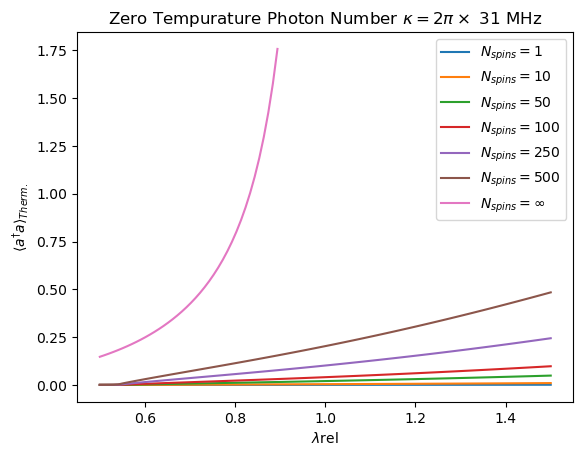

In [14]:
κ = 200.
Δc = 2π*20
ωz = 2π*0.01
λc = 1/2*sqrt((Δc^2+κ^2)/Δc * ωz) 

λrelsBelow = λrels[1:40]

adagaInf = (λrelsBelow*λc).^2 ./ (2*ωz*Δc*(1 .- λrelsBelow.^2))

for j in 1:length(Nspins)
    plot(λrels, PNK200[:,j], label="\$N_{spins}=$(Nspins[j])\$")
end
plot(λrelsBelow, adagaInf, label="\$N_{spins}=\\infty\$")
PyPlot.xlabel("\$\\lambda\$rel")
PyPlot.ylabel("\$\\langle a^\\dag a \\rangle_{Therm.}\$")
PyPlot.title("Zero Tempurature Photon Number \$\\kappa=2\\pi\\times\$ 31 MHz")
PyPlot.legend()
PyPlot.display_figs()

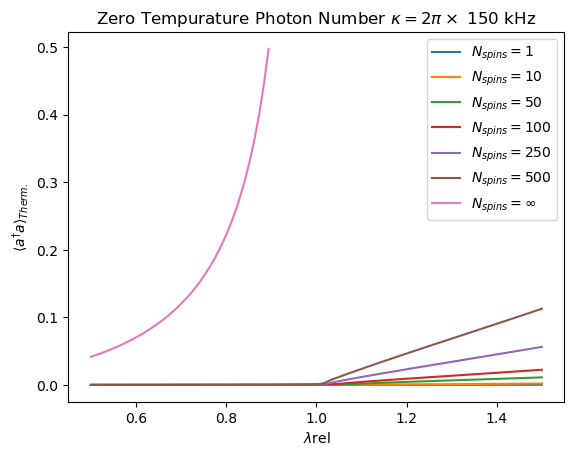

In [12]:
κ = 2π*0.15
Δc = 2π*20
ωz = 2π*0.01
λc = 1/2*sqrt((Δc^2+κ^2)/Δc * ωz) 

λrelsBelow = λrels[1:40]

adagaInf = (λrelsBelow*λc).^2 ./ (2*ωz*Δc*(1 .- λrelsBelow.^2))

for j in 1:length(Nspins)
    plot(λrels, PNK0150[:,j], label="\$N_{spins}=$(Nspins[j])\$")
end
plot(λrelsBelow, adagaInf, label="\$N_{spins}=\\infty\$")
PyPlot.xlabel("\$\\lambda\$rel")
PyPlot.ylabel("\$\\langle a^\\dag a \\rangle_{Therm.}\$")
PyPlot.title("Zero Tempurature Photon Number \$\\kappa=2\\pi\\times\$ 150 kHz")
PyPlot.legend()
PyPlot.display_figs()

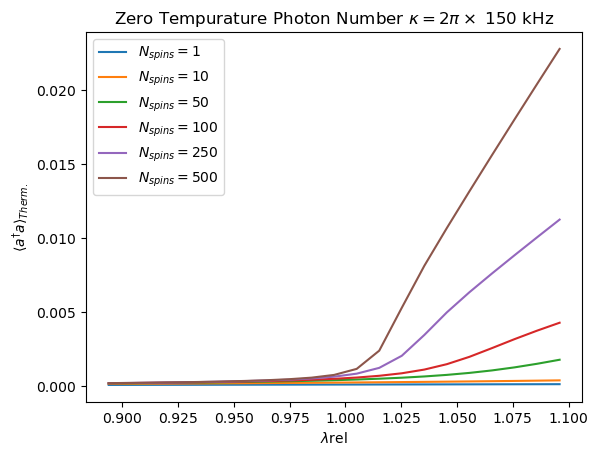

In [13]:
for j in 1:length(Nspins)
    plot(λrels[40:60], PNK0150[40:60,j], label="\$N_{spins}=$(Nspins[j])\$")
end
PyPlot.xlabel("\$\\lambda\$rel")
PyPlot.ylabel("\$\\langle a^\\dag a \\rangle_{Therm.}\$")
PyPlot.title("Zero Tempurature Photon Number \$\\kappa=2\\pi\\times\$ 150 kHz")
PyPlot.legend()
PyPlot.display_figs()

In [ ]:
κ = 2π*0.15
Δc = 2π*20
ωz = 2π*0.01
λc = 1/2*sqrt((Δc^2+κ^2)/Δc * ωz) 

λrelsBelow = λrels[1:40]

adagaInf = (λrelsBelow*λc).^2 ./ (2*ωz*Δc*(1 .- λrelsBelow.^2))

for j in 1:length(Nspins)
    plot(λrels, PN[:,j], label="\$N_{spins}=$(Nspins[j])\$")
end
plot(λrelsBelow, adagaInf, label="\$N_{spins}=\\infty\$")
PyPlot.xlabel("\$\\lambda\$rel")
PyPlot.ylabel("\$\\langle a^\\dag a \\rangle_{Therm.}\$")
PyPlot.title("Zero Tempurature Photon Number")
PyPlot.legend()
PyPlot.display_figs()

In [11]:
num_points = 100
λrels = LinRange(0.5, 1.5, num_points)
Nspins = [10,50,100,250]
PNSS = zeros(num_points, length(Nspins))

for i in 1:num_points
    for j in 1:length(Nspins)
        ρ_it, fb, sb, bases, a, Sx, Sy, Sz = dicke_model_SS_rho(λrels[i], Nspin=Nspins[j], κ=200.0)
        PNSS[i,j] = real(expect(dagger(a)*a, ρ_it))
        println("Finished running lambda=$(λrels[i]) Nspin=$(Nspins[j])")
    end
end

In [1]:
κ = 2π*0.15
Δc = 2π*20
ωz = 2π*0.01
λc = 1/2*sqrt((Δc^2+κ^2)/Δc * ωz) 

λrelsBelow = λrels[1:40]

adagaInf = (λrelsBelow*λc).^2 ./ (2*ωz*Δc*(1 .- λrelsBelow.^2))

for j in 1:length(Nspins)
    plot(λrels, PNSS[:,j], label="\$N_{spins}=$(Nspins[j])\$")
end
plot(λrelsBelow, adagaInf, label="\$N_{spins}=\\infty\$")
PyPlot.xlabel("\$\\lambda\$rel")
PyPlot.ylabel("\$\\langle a^\\dag a \\rangle_{S.S.}\$")
PyPlot.title("Steady State Photon Number")
PyPlot.legend()
PyPlot.display_figs()

UndefVarError: UndefVarError: `λrels` not defined